In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"sales.csv",
                 parse_dates=["date"])
df

,date,sales
0,2020-01-01,3.0
1,2020-01-02,13.0
2,2020-01-03,6.0
3,2020-01-04,6.0
4,2020-01-05,13.0
...,...,...
1669,2024-07-27,305.0
1670,2024-07-28,360.0
1671,2024-07-29,386.0
1672,2024-07-30,319.0


In [198]:
df[df.isnull().any(axis=1)]

,date,sales
358,2020-12-24,NaN
723,2021-12-24,NaN
1088,2022-12-24,NaN
1454,2023-12-25,NaN


In [ ]:
def fill_mean_local(idx, n=20):
    df.loc[idx, "sales"] = df.iloc[idx-n:idx+n].mean()["sales"]

fill_mean_local(358)
fill_mean_local(723)
fill_mean_local(1088)
fill_mean_local(1454)

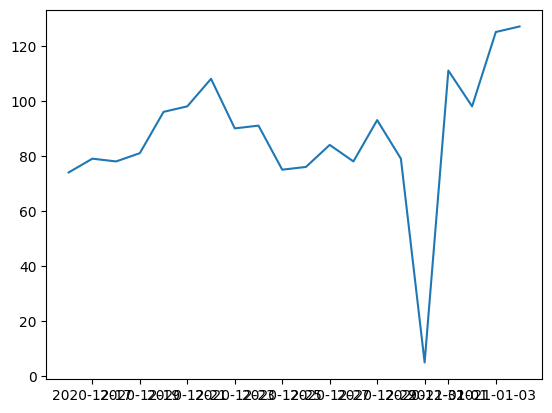

In [200]:
import matplotlib.pyplot as plt

plt.plot(df["date"].iloc[350:370], df["sales"].iloc[350:370])

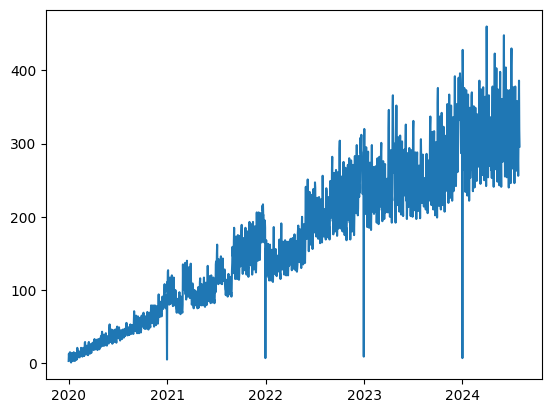

In [201]:
plt.plot(df["date"], df["sales"])

In [202]:
df[(df["sales"] < 50) & (df["date"] > pd.to_datetime("2020-11-05"))]

,date,sales
365,2020-12-31,5.0
730,2021-12-31,7.0
1095,2022-12-31,9.0
1461,2024-01-01,7.0


In [203]:
fill_mean_local(365)
fill_mean_local(730)
fill_mean_local(1095)
fill_mean_local(1461)

# df = df.drop(index=[365, 730, 1095, 1461])

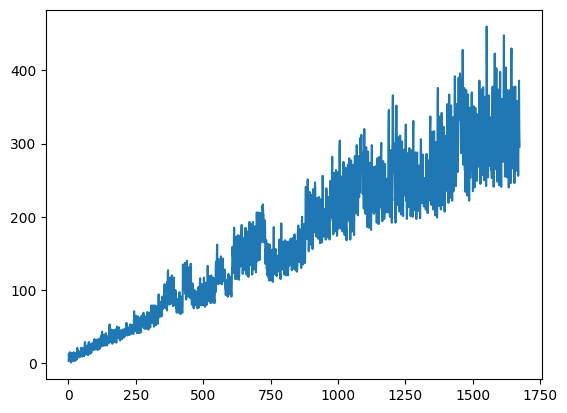

In [204]:
plt.plot(np.arange(1, len(df["date"])+1), df["sales"]) # df["date"]

In [ ]:
# df = pd.read_csv(r"sales.csv",
#                  parse_dates=["date"])
# df = df.drop(index=[365, 730, 1095, 1461])
# df = df.dropna()

In [255]:
from scipy.optimize import curve_fit

t = np.arange(1, len(df["date"])+1)

def model(t, a, b):
    return a*t + b

params, _ = curve_fit(model, t, df["sales"].to_numpy())
params

array([0.19446998, 6.04192812])

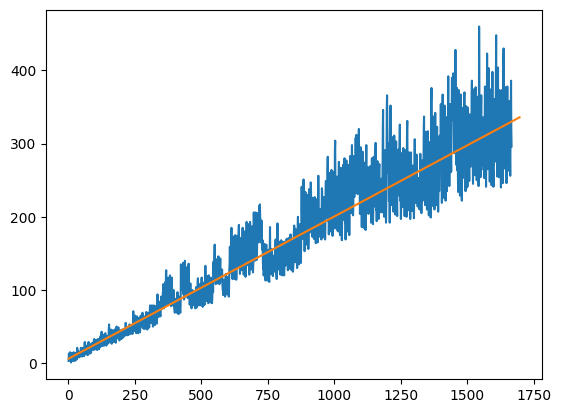

In [256]:
t1 = np.arange(1, (len(df["date"])+1)+30)

y = model(t1, params[0], params[1])

plt.plot(np.arange(1, len(df["date"])+1), df["sales"]) # df["date"]
plt.plot(t1, y)

In [257]:
t1 = np.arange((len(df["date"])+1), (len(df["date"])+1)+31)

y = model(t1, params[0], params[1])
y.max() - y.min()

np.float64(5.834099277934854)

In [258]:
from scipy.optimize import minimize

def minimize_method(x, y, model_func, init_guess):
    """
    Параметры:
    - x, y: данные
    - model_func: функция модели, принимает (x, *params)
    - init_guess: начальное приближение [a, b, ...]
    """
    
    def error_function(params, x, y):
        predictions = model_func(x, *params)
        return np.sum((y - predictions)**2)
    
    result = minimize(
        error_function,
        x0=init_guess,
        args=(x, y),
        method='BFGS'  # Градиентный спуск
    )
    
    return result.x, result.fun

params, _ = minimize_method(t, df["sales"].to_numpy(), model, init_guess=[0, 0])
print(params, _)

t1 = np.arange((len(df["date"])+1), (len(df["date"])+1)+30)
# t1 = np.arange(1, 31)
y = model(t1, params[0], params[1])
y.max() - y.min()

[0.19446996 6.04194175] 1628990.2507744562


np.float64(5.639628730374284)

In [259]:
from tqdm import tqdm

def grid_search_simple(x, y, param_range_x1, param_range_y1, param_range_x2, param_range_y2):
    # Диапазон параметров
    a_values = np.linspace(param_range_x1, param_range_y1, 400) # Значения
    b_values = np.linspace(param_range_x2, param_range_y2, 400) # Значения
    best_error = float('inf')
    best_a = None

    for a in tqdm(a_values):
        for b in b_values:
            temp = [(y_i - (a * x_i + b))**2 for x_i, y_i in zip(x, y)]
            error = sum(temp)/len(temp)  # Функция + x + y
            if error < best_error:  
                best_error = error
                best_a = a
                best_b = b

    print(f"Лучший параметр: {best_a} {best_b}")
    return best_a, best_b

params = grid_search_simple(t, df["sales"].to_numpy(), 0.19, 0.2, 6.1, 6.3)

100%|██████████| 400/400 [01:21<00:00,  4.92it/s]

Лучший параметр: 0.1944110275689223 6.1


In [260]:
t1 = np.arange((len(df["date"])+1), (len(df["date"])+1)+30)
print(len(t1))

y = model(t1, params[0], params[1])
y.max() - y.min()

30


np.float64(5.637919799498775)

In [261]:
from sklearn.linear_model import LinearRegression

def sklearn_method(x, y, feature_functions):
    """
    feature_functions: список функций для признаков
    Пример: [lambda x: x, lambda x: x**2, lambda x: np.sin(x)]
    """
    # Создать матрицу признаков
    X = np.column_stack([f(x) for f in feature_functions])
    
    model = LinearRegression()
    model.fit(X, y)
    
    params = list(model.coef_) + [model.intercept_]
    predictions = model.predict(X)
    error = np.sum((y - predictions)**2)
    
    return params, error

# Пример: y = a1*x + a2*x² + a3*sin(x) + b
features = [lambda t: t]
params, error = sklearn_method(t, df["sales"].to_numpy(), features)
params

[np.float64(0.1944699759311627), np.float64(6.041928122600382)]

In [262]:
t1 = np.arange((len(df["date"])+1), (len(df["date"])+1)+30)
print(len(t1))

y = model(t1, params[0], params[1])
y.max() - y.min()

30


np.float64(5.639629302003698)